In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import fit as fit_module
import Reaction_ODE_Fitting as ode
from importlib import reload

def import_data(file_name):
    df = pd.read_csv(file_name)
    return df

In [152]:
data = {}

for file in os.listdir('/Users/jacob/Documents/Water_Splitting/HTE_Photocatalysis/photocat-hte/data/MRG-059_Q_to_T'):
    if file.endswith('.csv'):
        df = import_data(f'/Users/jacob/Documents/Water_Splitting/HTE_Photocatalysis/photocat-hte/data/MRG-059_Q_to_T/{file}')
        fit_module.align_time(df)
        data[file] = {'dataframe': df}

print(data)

{'results_MRG-059-Q.csv': {'dataframe':           timestamp             datetime                 status  \
0      1.720155e+09  2024-07-05 06:54:00                  OTHER   
1      1.720155e+09  2024-07-05 06:54:00                  OTHER   
2      1.720155e+09  2024-07-05 06:54:00                  OTHER   
3      1.720155e+09  2024-07-05 06:54:00                  OTHER   
4      1.720155e+09  2024-07-05 06:54:00                  OTHER   
...             ...                  ...                    ...   
14577  1.720160e+09  2024-07-05 08:15:26  POSTREACTION-BASELINE   
14578  1.720160e+09  2024-07-05 08:15:29  POSTREACTION-BASELINE   
14579  1.720160e+09  2024-07-05 08:15:33  POSTREACTION-BASELINE   
14580  1.720160e+09  2024-07-05 08:15:36  POSTREACTION-BASELINE   
14581  1.720160e+09  2024-07-05 08:15:40  POSTREACTION-BASELINE   

              command  status_1  dphi_1       uM_1     mbar_1   airSat_1  \
0      FIRESTING-STOP       NaN     NaN        NaN        NaN        NaN   
1  

In [153]:
reload(fit_module)

rates_simple = []

for reaction in data:
    df = data[reaction]['dataframe']
    rate, data_subset, data_corrected, rxn_start, rxn_end = fit_module.fit_data(df, offset = 0, return_full = True)
    rates_simple.append(rate)

    time = data_subset["duration"].values
    o2_data = data_subset["uM_1"].values

    time_reaction = data_corrected[:,0][rxn_start:rxn_end] - data_corrected[:,0][rxn_start]
    data_reaction = data_corrected[:,1][rxn_start:rxn_end]

    idx = np.argmax(data_reaction)
    time_reaction = time_reaction[:idx]
    data_reaction = data_reaction[:idx]

    data[reaction]['time_reaction'] = time_reaction
    data[reaction]['data_reaction'] = data_reaction



In [154]:
reload(ode)

def fitting_to_data(data, reaction_string, bounds, idx):

    fig, ax = plt.subplots()
    ax.set_xlabel('Time / s')
    ax.set_ylabel(r'Oxygen / $\mu$mol/L')

    color = ['red', 'blue', 'green', 'orange', 'brown']

    p_results = []
    other_results = [[], []]

    for counter, reaction in enumerate(data):
        p, matrix, initial_state, residual = ode.ODE_fitting(data[reaction]['data_reaction'], 
                                                            data[reaction]['time_reaction'], 
                                    reaction_string, idx = idx, bounds_arr = bounds)       
        y_fit = ode.ODE_matrix_fit_func(p, initial_state, data[reaction]['time_reaction'], matrix, idx = idx)
        max_rate = np.amax(np.diff(y_fit))

        data[reaction]['p'] = p
        data[reaction]['max_rate'] = max_rate
        data[reaction]['residual'] = residual
        data[reaction]['y_fit'] = y_fit

        p_results.append(p)
        other_results[0].append(max_rate)
        other_results[1].append(residual)
        
        ax.plot(data[reaction]['time_reaction'], data[reaction]['data_reaction'], '.', label = file, color = color[counter])
        ax.plot(data[reaction]['time_reaction'], y_fit, label = file + '-Fit', color = color[counter])

    return np.asarray(p_results), np.asarray(other_results)

def calculate_descriptors(p_results, other_results, idx_p):

    def max_deviation(data):
        max = np.amax(data)
        min = np.amin(data)

        return (max/min - 1) * 100

    other_average = np.average(other_results, axis = 1)

    print('--------- max rates -----------') 
    print(other_results[0])
    print('-------------------------------')
    print('Average max rate:                    ', other_average[0])
    print('Variance max rate:                   ', np.var(other_results[0]))
    print('Standard deviation max rate:         ', np.std(other_results[0]))
    print('Max of max rate:                     ', np.amax(other_results[0]))
    print('Min of max rate:                     ', np.amin(other_results[0]))
    print('% deviation min/max of max rate:     ', max_deviation(other_results[0]), '%')
    print('--------------------------------------------------------------------')

    print('--------- p values -----------')
    print(p_results[:,idx_p])
    print('-------------------------------')
    print('Average p:                           ', np.average(p_results[:,idx_p]))
    print('Variance p:                          ', np.var(p_results[:,idx_p]))
    print('Standard deviation p:                ', np.std(p_results[:,idx_p]))
    print('Max of p:                            ', np.amax(p_results[:,idx_p]))
    print('Min of p:                            ', np.amin(p_results[:,idx_p]))
    print('% deviation min/max of p:            ', max_deviation(p_results[:,idx_p]), '%')
    print('--------------------------------------------------------------------')
    
    print('--------- residuals -----------') 
    print(other_results[1])
    print('-------------------------------')
    print('Average residual:                    ', other_average[1])


In [155]:
rates_simple = np.asarray(rates_simple)
print((np.max(rates_simple)/np.min(rates_simple)-1)*100)


11.071666048150885


--------- max rates -----------
[4.7970417  5.01335618 4.54221368 4.13672357 4.536782  ]
-------------------------------
Average max rate:                     4.605223423789891
Variance max rate:                    0.08630263425930755
Standard deviation max rate:          0.2937730999586374
Max of max rate:                      5.013356179485296
Min of max rate:                      4.136723565343646
% deviation min/max of max rate:      21.1914719534523 %
--------------------------------------------------------------------
--------- p values -----------
[0.01639757 0.01731677 0.01787571 0.01821145 0.01812643]
-------------------------------
Average p:                            0.01758558823010479
Variance p:                           4.5040449121526913e-07
Standard deviation p:                 0.000671121815481563
Max of p:                             0.018211447295269856
Min of p:                             0.016397573867218462
% deviation min/max of p:             11.0618402620989

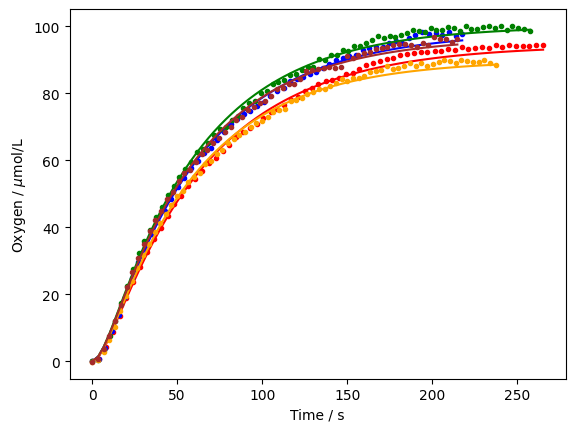

In [156]:
reaction_string = ['A > B, k1',
                   'B > C, k2']

bounds = [[0, 1], [0.15, 0.15]]
idx = 2

p_results, other_results = fitting_to_data(data, reaction_string, bounds, idx)

calculate_descriptors(p_results, other_results, idx_p = 0)

--------- max rates -----------
[5.32504297 5.73732672 5.21221467 4.66466187 5.11673226]
-------------------------------
Average max rate:                     5.211195697553835
Variance max rate:                    0.11947973320704823
Standard deviation max rate:          0.34565840537595527
Max of max rate:                      5.737326722995136
Min of max rate:                      4.664661867004721
% deviation min/max of max rate:      22.995554374002158 %
--------------------------------------------------------------------
--------- p values -----------
[0.0147221  0.0154173  0.01589312 0.0161455  0.0160578 ]
-------------------------------
Average p:                            0.015647164028080536
Variance p:                           2.772069716574653e-07
Standard deviation p:                 0.0005265044839860961
Max of p:                             0.016145499885147782
Min of p:                             0.014722099676181537
% deviation min/max of p:             9.6684592569

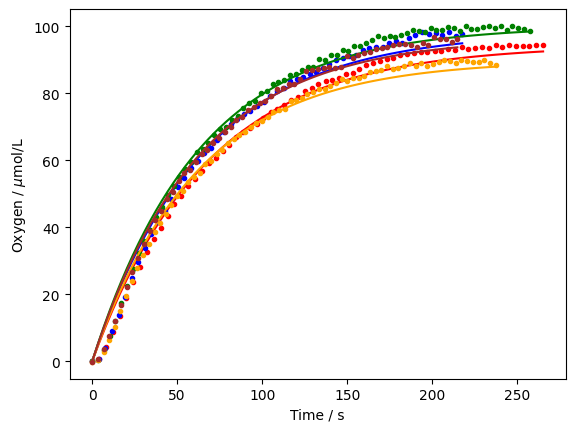

In [157]:
reaction_string = ['A > B, k1']
idx = 1

p_results, other_results = fitting_to_data(data, reaction_string, None, idx)

calculate_descriptors(p_results, other_results, idx_p = 0)

--------- max rates -----------
[4.74292464 4.97362717 4.54394809 4.12912022 4.5753967 ]
-------------------------------
Average max rate:                     4.593003363009775
Variance max rate:                    0.07705097146184192
Standard deviation max rate:          0.27758056751480625
Max of max rate:                      4.973627170385907
Min of max rate:                      4.129120218027552
% deviation min/max of max rate:      20.452467057541114 %
--------------------------------------------------------------------
--------- p values -----------
[0.12913689 0.01763593 0.0178679  0.01833074 0.01793679]
-------------------------------
Average p:                            0.04018164686303036
Variance p:                           0.0019783088149384824
Standard deviation p:                 0.044478183584072795
Max of p:                             0.1291368884747161
Min of p:                             0.017635926327224865
% deviation min/max of p:             632.237627208531

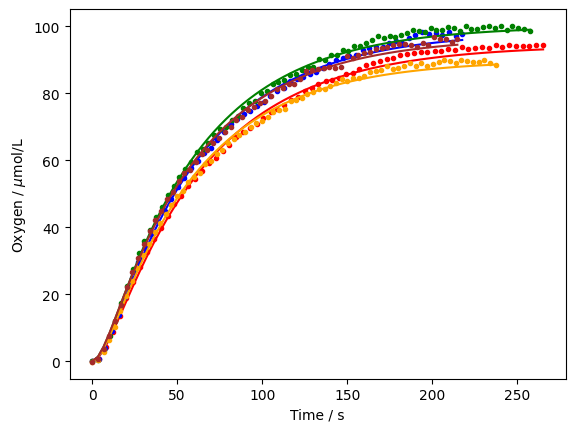

In [158]:
reaction_string = ['A > B, k1',
                   'B > C, k2']

bounds = [[0, 1], [0, 1]]
idx = 2

p_results, other_results = fitting_to_data(data, reaction_string, bounds, idx)

calculate_descriptors(p_results, other_results, idx_p = 0)

--------- max rates -----------
[4.79704434 5.01335622 4.54221275 4.13700592 4.5367814 ]
-------------------------------
Average max rate:                     4.605280128207001
Variance max rate:                    0.08624998186684449
Standard deviation max rate:          0.29368347223983254
Max of max rate:                      5.013356223145394
Min of max rate:                      4.1370059243869175
% deviation min/max of max rate:      21.183201445096955 %
--------------------------------------------------------------------
--------- p values -----------
[0.01639758 0.01731678 0.01787571 0.01821306 0.01812643]
-------------------------------
Average p:                            0.017585910971471153
Variance p:                           4.5080178625599375e-07
Standard deviation p:                 0.0006714177434771841
Max of p:                             0.01821305744167394
Min of p:                             0.016397584497139947
% deviation min/max of p:             11.07158767

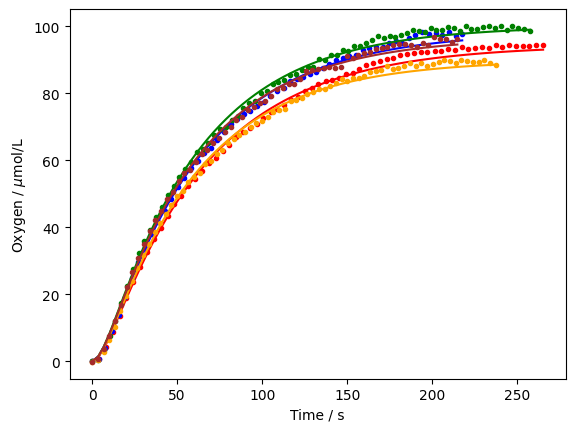

In [159]:
reaction_string = ['A > B, k1',
                   'B > C, k2']

bounds = [[0.15, 0.15], [0, 1]]
idx = 2

p_results, other_results = fitting_to_data(data, reaction_string, bounds, idx)

calculate_descriptors(p_results, other_results, idx_p = 1)

--------- max rates -----------
[4.74292467 4.97362681 4.5439533  4.12916026 4.57539841]
-------------------------------
Average max rate:                     4.593012689327639
Variance max rate:                    0.07704337450673651
Standard deviation max rate:          0.27756688294307824
Max of max rate:                      4.973626808372654
Min of max rate:                      4.129160260823165
% deviation min/max of max rate:      20.45129019480443 %
--------------------------------------------------------------------
--------- p values -----------
[0.1291357  0.13097423 0.15052105 0.14295187 0.16327456]
-------------------------------
Average p:                            0.14337148069140676
Variance p:                           0.00016075488668667706
Standard deviation p:                 0.012678915043751854
Max of p:                             0.16327456075232474
Min of p:                             0.12913569633589594
% deviation min/max of p:             26.4364272506262

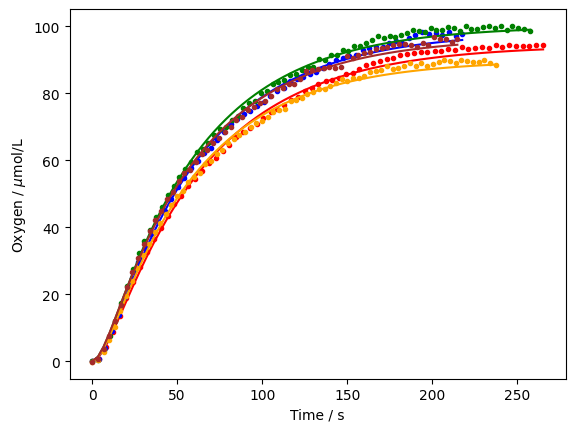

In [160]:
reaction_string = ['A > B, k1',
                   'B > C, k2']

bounds = [[0.01, 0.05], [0, 1]]
idx = 2

p_results, other_results = fitting_to_data(data, reaction_string, bounds, idx)

calculate_descriptors(p_results, other_results, idx_p = 1)

--------- max rates -----------
[4.96114004 5.19390325 4.63478172 4.14027052 4.63063743]
-------------------------------
Average max rate:                     4.712146593236648
Variance max rate:                    0.12675170473626485
Standard deviation max rate:          0.3560220565305819
Max of max rate:                      5.19390325018931
Min of max rate:                      4.1402705183452415
% deviation min/max of max rate:      25.448403121861183 %
--------------------------------------------------------------------
--------- p values -----------
[0.01593946 0.01679536 0.01732967 0.01764274 0.01755639]
-------------------------------
Average p:                            0.017052725114853336
Variance p:                           3.968197236123493e-07
Standard deviation p:                 0.0006299362853593603
Max of p:                             0.01764274281131463
Min of p:                             0.015939460401755798
% deviation min/max of p:             10.68594774620

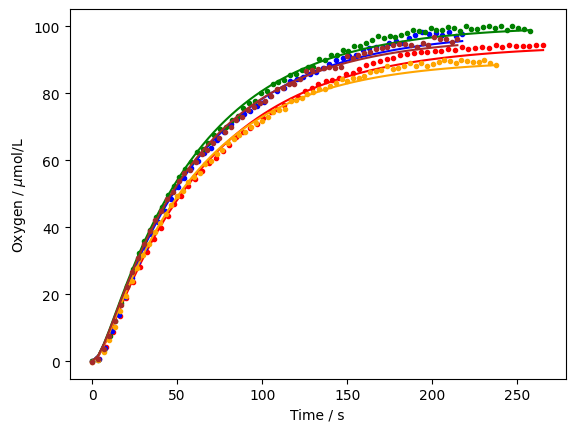

In [161]:
reaction_string = ['A > B, k1',
                   'B > C, k2']

bounds = [[0.2, 0.2], [0, 1]]
idx = 2

p_results, other_results = fitting_to_data(data, reaction_string, bounds, idx)

calculate_descriptors(p_results, other_results, idx_p = 1)

--------- max rates -----------
[5.21888949 5.35694964 5.07759394 4.38204091 4.75780111]
-------------------------------
Average max rate:                     4.958655018473435
Variance max rate:                    0.12266663583969255
Standard deviation max rate:          0.3502379702997557
Max of max rate:                      5.3569496376598895
Min of max rate:                      4.382040905834234
% deviation min/max of max rate:      22.247823623181272 %
--------------------------------------------------------------------
--------- p values -----------
[0.01518235 0.01593695 0.01643373 0.01670832 0.01662162]
-------------------------------
Average p:                            0.016176595859306076
Variance p:                           3.1856838976625274e-07
Standard deviation p:                 0.0005644186298894223
Max of p:                             0.016708320947960466
Min of p:                             0.015182354986838108
% deviation min/max of p:             10.05091741

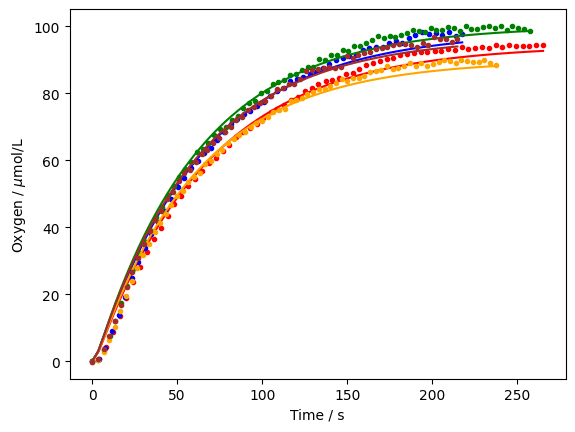

In [162]:
reaction_string = ['A > B, k1',
                   'B > C, k2']

bounds = [[0.5, 0.5], [0, 1]]
idx = 2

p_results, other_results = fitting_to_data(data, reaction_string, bounds, idx)

calculate_descriptors(p_results, other_results, idx_p = 1)